<a href="https://colab.research.google.com/github/Josephbousaleh/ecovision/blob/main/LSAM_ECOVISION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code includes in part the use of the `Language Segment-Anything (LangSAM)` package. Developed by Engineer Luca Medeiros, LangSAM is an open-source project designed to combine the capabilities of instance segmentation and text prompts for generating masks for specific objects in images. Here, we modified it so it can perform multiple segmentations on remote sensing imagery.

LangSAM is built upon the Meta model and the `segment-anything` repository. Furthermore, it uses the GroundingDINO detection model, providing a comprehensive and effective tool for object detection and image segmentation.

The LangSAM package is user-friendly and designed to streamline and simplify the process of object detection and image segmentation.

For more comprehensive information, further details, and examples on how to use LangSAM, you can visit Luca Medeiros's GitHub page at https://github.com/luca-medeiros/lang-segment-anything.

---
For those not running this on Google Colab, please ensure you have correctly installed GroundingDINO. You'll need Microsoft C++ Build Tools and Git. Follow the steps below:

1. **Microsoft C++ Build Tools**: Install this software, which provides the tools necessary for compiling and linking C++ code, by visiting [this link](https://visualstudio.microsoft.com/visual-cpp-build-tools/).

2. **Git**: Git is a distributed version control system that's used to track changes in source code during software development. Install it from the official Git website: [https://git-scm.com/](https://git-scm.com/).

    - During the installation process, ensure you select the option to add Git to your system's PATH environment variable. This allows you to run Git commands from the command prompt or terminal on your system.

After successfully installing these tools, you may need to restart your computer to ensure all changes take effect. This will facilitate the successful installation and functioning of GroundingDINO on your local environment.

In [ ]:
# Install the necessary libraries
!pip install rasterio geopandas fiona shapely torch torchvision segment-anything huggingface_hub \
    -U git+https://github.com/IDEA-Research/GroundingDINO.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-82njv5ds
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-82njv5ds
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 31aa788a3cf6ab82d27385f39e242b34af9cc011
  Preparing metadata (setup.py) ... done


In [ ]:
# Import required libraries
import os
import numpy as np
import torch
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import groundingdino.datasets.transforms as T
from PIL import Image
from rasterio.plot import show
from matplotlib.patches import Rectangle
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry
from segment_anything import SamPredictor
from shapely.geometry import shape
from rasterio.features import shapes

In [ ]:
# Define constants
SAM_MODELS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}

# Default cache path for model checkpoints
CACHE_PATH = os.environ.get("TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints"))

In [ ]:
# Define helper functions
def load_model_hf(repo_id: str, filename: str, ckpt_config_filename: str, device: str = 'cpu') -> torch.nn.Module:
    """
    Loads a model from HuggingFace Model Hub.

    Parameters:
    repo_id (str): Repository ID on HuggingFace Model Hub.
    filename (str): Name of the model file in the repository.
    ckpt_config_filename (str): Name of the config file for the model in the repository.
    device (str): Device to load the model onto. Default is 'cpu'.

    Returns:
    torch.nn.Module: The loaded model.
    """
    # Ensure the repo ID and filenames are valid
    assert isinstance(repo_id, str) and repo_id, "Invalid repository ID"
    assert isinstance(filename, str) and filename, "Invalid model filename"
    assert isinstance(ckpt_config_filename, str) and ckpt_config_filename, "Invalid config filename"

    # Download the config file and build the model from it
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    model.to(device)

    # Download the model checkpoint and load it into the model
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    model.eval()

    return model

def transform_image(image: Image) -> torch.Tensor:
    """
    Transforms an image using standard transformations for image-based models.

    Parameters:
    image (Image): The PIL Image to be transformed.

    Returns:
    torch.Tensor: The transformed image as a tensor.
    """
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image_transformed, _ = transform(image, None)
    return image_transformed

In [ ]:
# Class definition for LangSAM
class LangSAM:
    """
    A Language-based Segment-Anything Model (LangSAM) class which combines GroundingDINO and SAM.
    """
    def __init__(self, sam_type: str = "vit_h"):
        """
        Initialize the LangSAM instance.

        Parameters:
        sam_type (str): Type of SAM model to use. Default is "vit_h".
        """
        if sam_type not in SAM_MODELS:
            raise ValueError(f"Invalid SAM model type. Available options are {list(SAM_MODELS.keys())}.")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.build_groundingdino()
        self.build_sam(sam_type)

    def build_sam(self, sam_type: str):
        """
        Build the SAM model.

        Parameters:
        sam_type (str): Type of SAM model to use.
        """
        checkpoint_url = SAM_MODELS[sam_type]
        sam = sam_model_registry[sam_type]()
        state_dict = torch.hub.load_state_dict_from_url(checkpoint_url)
        sam.load_state_dict(state_dict, strict=True)
        sam.to(device=self.device)
        self.sam = SamPredictor(sam)

    def build_groundingdino(self):
        """
        Build the GroundingDINO model.
        """
        ckpt_repo_id = "ShilongLiu/GroundingDINO"
        ckpt_filename = "groundingdino_swinb_cogcoor.pth"
        ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
        self.groundingdino = load_model_hf(ckpt_repo_id, ckpt_filename, ckpt_config_filename, self.device)

    def predict_dino(self, image_pil, text_prompt, box_threshold, text_threshold):
        """
        Run the GroundingDINO model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        text_prompt (str): Text prompt for the model.
        box_threshold (float): Box threshold for the prediction.
        text_threshold (float): Text threshold for the prediction.

        Returns:
        Tuple containing boxes, logits, and phrases.
        """
        image_trans = transform_image(image_pil)
        boxes, logits, phrases = predict(model=self.groundingdino,
                                         image=image_trans,
                                         caption=text_prompt,
                                         box_threshold=box_threshold,
                                         text_threshold=text_threshold,
                                         device=self.device)
        W, H = image_pil.size
        boxes = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H]).to(boxes.device)  # Ensure tensor is on the same device
        return boxes, logits, phrases

    def predict_sam(self, image_pil: Image, boxes: torch.Tensor):
        """
        Run the SAM model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        boxes (torch.Tensor): Tensor of bounding boxes.

        Returns:
        Masks tensor.
        """
        image_array = np.array(image_pil)
        self.sam.set_image(image_array)
        transformed_boxes = self.sam.transform.apply_boxes_torch(boxes, image_array.shape[:2])
        masks, _, _ = self.sam.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes.to(self.sam.device),
            multimask_output=False,
        )
        return masks.cpu()

    def predict(self, image_pil: Image, text_prompt: str, box_threshold: float, text_threshold: float):
        """
        Run both GroundingDINO and SAM model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        text_prompt (str): Text prompt for the model.
        box_threshold (float): Box threshold for the prediction.
        text_threshold (float): Text threshold for the prediction.

        Returns:
        Tuple containing masks, boxes, phrases, and logits.
        """
        boxes, logits, phrases = self.predict_dino(image_pil, text_prompt, box_threshold, text_threshold)
        masks = torch.tensor([])
        if len(boxes) > 0:
            masks = self.predict_sam(image_pil, boxes)
            masks = masks.squeeze(1)
        return masks, boxes, phrases, logits

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  1 09:51:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install segment-geospatial leafmap localtileserver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [ ]:
m = leafmap.Map(center=[21.188896, 72.829560], zoom=15, height="800px")
m.add_basemap("SATELLITE")
m


Map(center=[21.188896, 72.82956], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6
Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=11148856.0, center=[51.569121114119504, 0.036762602626962966], controls=(ZoomControl(options=['posi…

In [ ]:
# Load the georeferenced image
with rasterio.open("satellite.tif") as src:
    image_np = src.read().transpose((1, 2, 0))  # Convert rasterio image to numpy array
    transform = src.transform  # Save georeferencing information
    crs = src.crs  # Save the Coordinate Reference System

In [ ]:
# Provide the text-prompt
text_prompt = "tree"

In [ ]:
# Initialize the model
model = LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects (*refer to line 4 in the next cell*). These threshold values range between 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

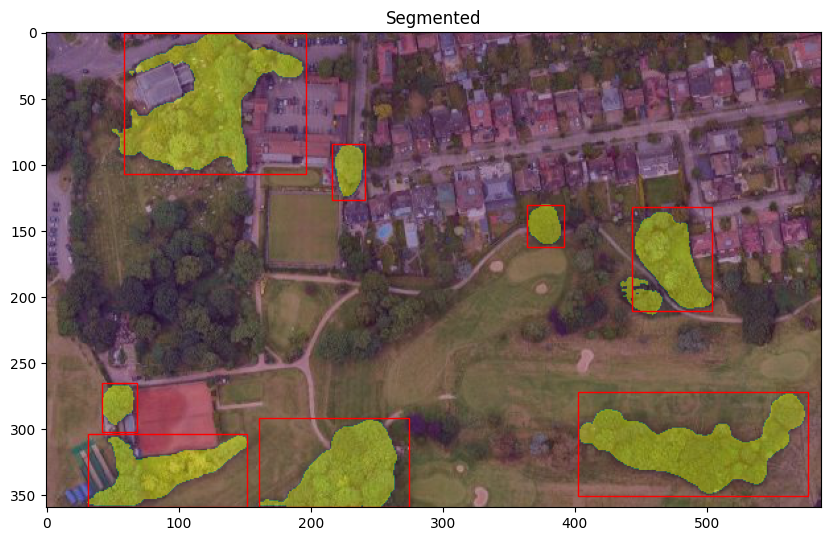

In [ ]:
# Segment the image
image_pil = Image.fromarray(image_np[:, :, :3])  # Convert numpy array to PIL image, excluding the alpha channel

masks, boxes, phrases, logits = model.predict(image_pil, text_prompt, box_threshold=0.28, text_threshold=0.28)  # Customize the box and text threshold values to your data

if boxes.nelement() == 0:  # No "object" instances found
    print('No objects found in the image.')
else:
    # Create an empty image to store the mask overlays
    mask_overlay = np.zeros_like(image_np[..., 0], dtype=np.uint8)  # Adjusted for single channel

    for i, (box, mask) in enumerate(zip(boxes, masks)):
        # Convert tensor to numpy array if necessary and ensure it contains integers
        if isinstance(mask, torch.Tensor):
          mask = mask.cpu().numpy().astype(np.uint8)  # If mask is on GPU, use .cpu() before .numpy()
        mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)  # Assign a unique value for each mask

    # Normalize mask_overlay to be in [0, 255]
    mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

    # Display the original image with all mask overlays and bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)

    for box in boxes:
        # Draw bounding box
        box = box.cpu().numpy()  # Convert the tensor to a numpy array
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
    plt.title(f"Segmented")
    plt.show()

In [ ]:
image_area = image_pil.size[0] * image_pil.size[1]  # Calculate the total area of the original image

patch_areas = []
for i, (box, mask) in enumerate(zip(boxes, masks)):
    # Convert tensor to numpy array if necessary and ensure it contains integers
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy().astype(np.uint8)

    # Calculate area of each patch
    patch_area = np.sum(mask)  # Sum of all non-zero pixels in the mask
    patch_areas.append(patch_area)

# Calculate total area of the patches
total_patch_area = sum(patch_areas)

# Calculate percentage of total patch area compared to the image area
patch_area_percentage = (total_patch_area / image_area) * 100

# Calculate percentages of each patch area relative to the image area
percentages = [(area / image_area) * 100 for area in patch_areas]

# Display the results
for i, (box, patch_area, percentage) in enumerate(zip(boxes, patch_areas, percentages)):
    print(f"Patch {i + 1}: Area = {patch_area}, Percentage = {percentage}% of Image Area = {image_area}")

print(f"Total Patch Area: {total_patch_area}, Percentage = {patch_area_percentage}% of Image Area")
print(f"Total Image Area: {image_area}")


Patch 1: Area = 3873, Percentage = 1.8327654741624078% of Image Area = 211320
Patch 2: Area = 548, Percentage = 0.25932235472269544% of Image Area = 211320
Patch 3: Area = 5755, Percentage = 2.7233579405640733% of Image Area = 211320
Patch 4: Area = 578, Percentage = 0.2735188339958357% of Image Area = 211320
Patch 5: Area = 2948, Percentage = 1.3950406965739162% of Image Area = 211320
Patch 6: Area = 640, Percentage = 0.3028582244936589% of Image Area = 211320
Patch 7: Area = 2857, Percentage = 1.3519780427787242% of Image Area = 211320
Patch 8: Area = 7338, Percentage = 3.4724588302101083% of Image Area = 211320
Total Patch Area: 24537.0, Percentage = 11.61130039750142% of Image Area
Total Image Area: 211320


In [ ]:
# Save the image as a GeoTIFF
mask_overlay = ((mask_overlay > 0) * 255).astype(rasterio.uint8)  # Binary mask in [0, 255]

# Save the mask_overlay as a new georeferenced raster
with rasterio.open(
    'mask.tif',
    'w',
    driver='GTiff',
    height=mask_overlay.shape[0],
    width=mask_overlay.shape[1],
    count=1,
    dtype=mask_overlay.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(mask_overlay, 1)

NameError: ignored

In [ ]:
# Save the individual segmentations into a multi-part ShapeFile
mask = mask_overlay.astype('int16')  # Convert the mask to integer type
results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) in enumerate(shapes(mask, transform=transform))
    if v == 255  # Add condition to only keep 'trees'
)

geoms = list(results)

gdf = gpd.GeoDataFrame.from_features(geoms)
gdf.crs = crs  # Assign the Coordinate Reference System of the original image

# Save to file
gdf.to_file("mask.shp")